In [1]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-cluster -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
!pip install -q torch-geometric

     |████████████████████████████████| 2.6MB 7.7MB/s 
     |████████████████████████████████| 1.4MB 8.1MB/s 
     |████████████████████████████████| 931kB 8.4MB/s 
     |████████████████████████████████| 225kB 9.1MB/s 
     |████████████████████████████████| 235kB 36.4MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from torchsummary import summary

from torch_geometric.datasets import ModelNet, ShapeNet
from torch_geometric.transforms import Compose, FixedPoints, SamplePoints, NormalizeScale
from torch_geometric.data import DataLoader

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import time

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
torch.__version__, device

('1.9.0+cu102', device(type='cuda'))

In [4]:
def visualize_mesh(pos, face):
    # from the tutorial https://colab.research.google.com/drive/1D45E5bUK3gQ40YpZo65ozs7hg5l-eo_U?usp=sharing#scrollTo=SvsEAR28LUI7
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.axes.zaxis.set_ticklabels([])
    ax.plot_trisurf(pos[:, 0], pos[:, 1], pos[:, 2], triangles=face.t(), antialiased=False)
    plt.show()


def visualize_points(points, ax=None, show_grid=False, is_shapenet=False):
    fig = plt.figure()
    if ax is None:
        ax = fig.gca(projection='3d')
    ax.patch.set_alpha(0)
    ax.view_init(elev=10., azim=240.)
    ax.grid(show_grid)
    if is_shapenet:
      ax.scatter(points[:,0], points[:,2], points[:,1], c=points[:,2], cmap='plasma', s=10)
    else:
      ax.scatter(points[:,0], points[:,1], points[:,2], c=points[:,1], cmap='plasma', s=10)
    

def visualize_real_and_generated_samples(samples, show_grid=False, is_shapenet=False):
    fig = plt.figure(figsize=(16, 8))
    for i, sample in enumerate(samples):
        ax = fig.add_subplot(1, 2, i+1, projection='3d')
        visualize_points(sample, ax, show_grid, is_shapenet)

In [ ]:
# import os
# import os.path as osp
# import shutil
# import glob

# import torch
# from torch_geometric.data import InMemoryDataset, download_url, extract_zip
# from torch_geometric.io import read_off

# class CustomModelNet(InMemoryDataset):
#     r"""The ModelNet10/40 datasets from the `"3D ShapeNets: A Deep
#     Representation for Volumetric Shapes"
#     <https://people.csail.mit.edu/khosla/papers/cvpr2015_wu.pdf>`_ paper,
#     containing CAD models of 10 and 40 categories, respectively.

#     .. note::

#         Data objects hold mesh faces instead of edge indices.
#         To convert the mesh to a graph, use the
#         :obj:`torch_geometric.transforms.FaceToEdge` as :obj:`pre_transform`.
#         To convert the mesh to a point cloud, use the
#         :obj:`torch_geometric.transforms.SamplePoints` as :obj:`transform` to
#         sample a fixed number of points on the mesh faces according to their
#         face area.

#     Args:
#         root (string): Root directory where the dataset should be saved.
#         name (string, optional): The name of the dataset (:obj:`"10"` for
#             ModelNet10, :obj:`"40"` for ModelNet40). (default: :obj:`"10"`)
#         train (bool, optional): If :obj:`True`, loads the training dataset,
#             otherwise the test dataset. (default: :obj:`True`)
#         transform (callable, optional): A function/transform that takes in an
#             :obj:`torch_geometric.data.Data` object and returns a transformed
#             version. The data object will be transformed before every access.
#             (default: :obj:`None`)
#         pre_transform (callable, optional): A function/transform that takes in
#             an :obj:`torch_geometric.data.Data` object and returns a
#             transformed version. The data object will be transformed before
#             being saved to disk. (default: :obj:`None`)
#         pre_filter (callable, optional): A function that takes in an
#             :obj:`torch_geometric.data.Data` object and returns a boolean
#             value, indicating whether the data object should be included in the
#             final dataset. (default: :obj:`None`)
#     """

#     urls = {
#         '10':
#         'http://vision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip',
#         '40': 'http://modelnet.cs.princeton.edu/ModelNet40.zip'
#     }

#     def __init__(self, root, name='10', train=True, transform=None,
#                  pre_transform=None, pre_filter=None, pre_filter_target=None):
#         assert name in ['10', '40']
#         self.name = name
#         self.pre_filter_target = pre_filter_target
#         super(CustomModelNet, self).__init__(root, transform, pre_transform,
#                                        pre_filter)
#         path = self.processed_paths[0] if train else self.processed_paths[1]
#         self.data, self.slices = torch.load(path)

#     @property
#     def raw_file_names(self):
#         return [
#             'bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor',
#             'night_stand', 'sofa', 'table', 'toilet'
#         ]

#     @property
#     def processed_file_names(self):
#         return ['training.pt', 'test.pt']

#     def download(self):
#         path = download_url(self.urls[self.name], self.root)
#         extract_zip(path, self.root)
#         os.unlink(path)
#         folder = osp.join(self.root, 'ModelNet{}'.format(self.name))
#         shutil.rmtree(self.raw_dir)
#         os.rename(folder, self.raw_dir)

#         # Delete osx metadata generated during compression of ModelNet10
#         metadata_folder = osp.join(self.root, '__MACOSX')
#         if osp.exists(metadata_folder):
#             shutil.rmtree(metadata_folder)

#     def process(self):
#         torch.save(self.process_set('train'), self.processed_paths[0])
#         torch.save(self.process_set('test'), self.processed_paths[1])

#     def process_set(self, dataset):
#         categories = glob.glob(osp.join(self.raw_dir, '*', ''))
#         categories = sorted([x.split(os.sep)[-2] for x in categories])

#         data_list = []
#         for target, category in enumerate(categories):
#             if self.pre_filter_target is not None and not self.pre_filter_target(target):
#                 continue
            
#             folder = osp.join(self.raw_dir, category, dataset)
#             paths = glob.glob('{}/{}_*.off'.format(folder, category))
                            
#             for path in paths:
#                 data = read_off(path)
#                 data.y = torch.tensor([target])
#                 data_list.append(data)

#         if self.pre_filter is not None:
#             data_list = [d for d in data_list if self.pre_filter(d)]

#         if self.pre_transform is not None:
#             data_list = [self.pre_transform(d) for d in data_list]

#         return self.collate(data_list)

#     def __repr__(self):
#         return '{}{}({})'.format(self.__class__.__name__, self.name, len(self))

## Process the data (ShapeNet or ModelNet)

In [17]:
shape_name = 'Airplane'

Processing...
Done!
ShapeNet(2349, categories=['Airplane'])
Data(category=[1], pos=[2518, 3], x=[2518, 3], y=[2518])
Data(category=[1], pos=[2712, 3], x=[2712, 3], y=[2712])


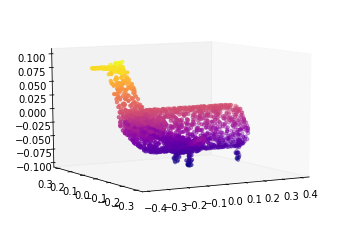

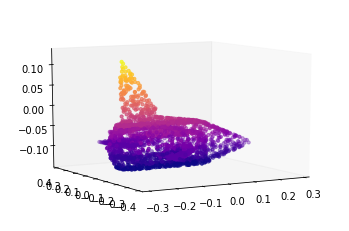

In [6]:
#dataset = ModelNet(root='E:\data\modelnet40_data', name='40')
#shape_label = 0
#dataset = CustomModelNet(root='.', name='40', pre_filter_target=lambda y: y == shape_label)


dataset = ShapeNet(root='.', categories=shape_name)


print(dataset)

data = dataset[0]
print(data)
# print(type(data.face), data.face)
# visualize_mesh(data.pos, data.face) # for ModelNet
visualize_points(data.pos, is_shapenet=True)


data = dataset[4]
print(data)
# visualize_mesh(data.pos, data.face) # for ModelNet
visualize_points(data.pos, is_shapenet=True)


### Normalize the position scale (for ModelNet) and sample and plot points

In [7]:
torch.manual_seed(11)

n_points = 2048 # number of points to sample
dataset.transform = FixedPoints(num=n_points) # samples points from a point cloud

# for ModelNet:
# SamplePoints samples points from a mesh
# dataset.transform = Compose([SamplePoints(num=n_points), NormalizeScale()])


Data(category=[1], pos=[2048, 3], x=[2048, 3], y=[2048])


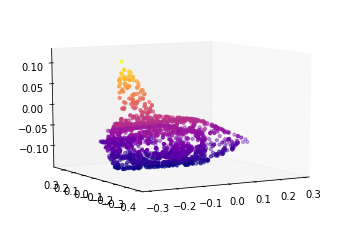

In [8]:
# sanity check:
data = dataset[4]
print(data)
visualize_points(data.pos, is_shapenet=True)

### Collect the data for a single class

In [9]:
# shape_label = 0
# single_class_data = dataset[dataset.data.y==shape_label]
single_class_data = dataset
n_shapes = len(single_class_data)
n_shapes

2349

## Raw GAN (r-GAN)

(See https://arxiv.org/pdf/1707.02392.pdf)

**Generator**

Input  128 --->  Linear 64 + ReLU  ---> Linear 128 + ReLU ---> Linear 512 + ReLU --->  Linear 1024 + ReLU  --->  Linear 2048*3

<br></br>

**Discriminator**

Input 2048x3 --->

ENCODER

Conv1D (2048, 64, kernel_size=1)   + LeakyReLU  --->  
Conv1D (64, 128, kernel_size=1)    + LeakyReLU --->
Conv1D (128, 256, kernel_size=1)   + LeakyReLU  --->
Conv1D (256, 256, kernel_size=1)   + LeakyReLU  --->
Conv1D (256, 512, kernel_size=1)   + LeakyReLU  --->
(output.shape = (512, 3))

--->

DECODER 

--->  Linear(512, 128) + ReLU ---> Linear(128, 64) + ReLU --->
--->  Linear(64, 1) + Sigmoid ---> Fake or Real


In [10]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64), nn.ReLU(True),
            nn.Linear(64, 128), nn.ReLU(True),
            nn.Linear(128, 512), nn.ReLU(True),
            nn.Linear(512, 1024), nn.ReLU(True),
            nn.Linear(1024, output_dim)
        )
        
    def forward(self, x):
        # reshape to batch_size x 3 x n_points
        samples = self.model(x).view(x.size(0), 3, -1)

        # TODO: try clipping the output to be in [-1, 1], e.g., by applying tanh
        # samples.clamp_(min=-1, max=1)

        return samples
    
    def init_params(self, layer):
        if type(layer) == nn.Linear:
            nn.init.xavier_uniform_(layer.weight.data)
            nn.init.zeros_(layer.bias.data)

In [11]:
# instantiate the r-GAN generator
raw_gan_gen_input_dim = 128
raw_gan_gen = Generator(raw_gan_gen_input_dim, n_points*3).to(device)

# initialize the parameters:
raw_gan_gen.apply(raw_gan_gen.init_params)

mu = 0.
sigma = 0.2

z = torch.FloatTensor(1, raw_gan_gen_input_dim).normal_(mu, sigma).to(device)

print(z.shape)
print(raw_gan_gen(z).shape)

summary(raw_gan_gen, (1, raw_gan_gen_input_dim))

torch.Size([1, 128])
torch.Size([1, 3, 2048])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]           8,256
              ReLU-2                [-1, 1, 64]               0
            Linear-3               [-1, 1, 128]           8,320
              ReLU-4               [-1, 1, 128]               0
            Linear-5               [-1, 1, 512]          66,048
              ReLU-6               [-1, 1, 512]               0
            Linear-7              [-1, 1, 1024]         525,312
              ReLU-8              [-1, 1, 1024]               0
            Linear-9              [-1, 1, 6144]       6,297,600
Total params: 6,905,536
Trainable params: 6,905,536
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 26.34
Estimated Total Size (MB

In [12]:
class Discriminator(nn.Module):
    def __init__(self, encoder_in_ch, encoder_out_ch):        
        super(Discriminator, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv1d(encoder_in_ch, 64, 1, 1), nn.LeakyReLU(0.2),
            nn.Conv1d(64, 128, 1, 1), nn.LeakyReLU(0.2),
            nn.Conv1d(128, 256, 1, 1), nn.LeakyReLU(0.2),
            nn.Conv1d(256, 256, 1, 1), nn.LeakyReLU(0.2),
            nn.Conv1d(256, encoder_out_ch, 1, 1), nn.LeakyReLU(0.2)
        )
        # outputs (batch_size x encoder_out_ch x n_points)
        # we then maxpool the output in the forward method, 
        # so the input to the decoder becomes (batch_size x encoder_out_ch)
        
        self.decoder = nn.Sequential(
            nn.Linear(encoder_out_ch, 128), nn.ReLU(True),
            nn.Linear(128, 64), nn.ReLU(True),
            nn.Linear(64, 1), nn.Sigmoid(),
        )
   

    def forward(self, x):
        x = self.encoder(x)
        x, _ = torch.max(x, dim=-1)
        x = self.decoder(x)
        return x
            
            
    def init_params(self, layer):
        if type(layer) == nn.Conv1d:
            nn.init.kaiming_uniform_(layer.weight.data)
            nn.init.zeros_(layer.bias.data)            
        if type(layer) == nn.Linear:
            nn.init.xavier_uniform_(layer.weight.data)
            nn.init.zeros_(layer.bias.data)

In [13]:
# instantiate the r-GAN discriminator:
raw_gan_dis_input_ch = 3
raw_gan_dis = Discriminator(raw_gan_dis_input_ch, 512).to(device)

# initialize the parameters:
raw_gan_dis.apply(raw_gan_dis.init_params)

# print the summary:
y = torch.ones((1, 3, 2048)).to(device)
print(y.shape)

pred = raw_gan_dis(y)
print(pred.shape)

summary(raw_gan_dis, (raw_gan_dis_input_ch, 2048))

torch.Size([1, 3, 2048])
torch.Size([1, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 2048]             256
         LeakyReLU-2             [-1, 64, 2048]               0
            Conv1d-3            [-1, 128, 2048]           8,320
         LeakyReLU-4            [-1, 128, 2048]               0
            Conv1d-5            [-1, 256, 2048]          33,024
         LeakyReLU-6            [-1, 256, 2048]               0
            Conv1d-7            [-1, 256, 2048]          65,792
         LeakyReLU-8            [-1, 256, 2048]               0
            Conv1d-9            [-1, 512, 2048]         131,584
        LeakyReLU-10            [-1, 512, 2048]               0
           Linear-11                  [-1, 128]          65,664
             ReLU-12                  [-1, 128]               0
           Linear-13                   [-1, 64]           8

## Optimize the r-GAN

### Optimization setup

In [14]:
# hyperparameters:
lr_gen = 1e-4
lr_dis = 1e-4
beta1 = 0.5
beta2 = 0.999

# two separate optimizers for the generator and discriminator:
optimizer_gen = optim.Adam(params=raw_gan_gen.parameters(), 
                           lr=lr_gen, 
                           betas=(beta1, beta2))

optimizer_dis = optim.Adam(params=raw_gan_dis.parameters(), 
                           lr=lr_dis, 
                           betas=(beta1, beta2))

# by supplying with the correct labels, we will make it 
# equivalent to using non-saturating heuristic for the generator
# and the standard binary cross-entropy for the discriminator
criterion = nn.BCELoss().to(device)
criterion_gen = criterion # nn.BCELoss().to(device)
criterion_dis = criterion # nn.BCELoss().to(device)

### Create a dataloader for our single class dataset

In [15]:
batch_size = 50
dataloader = DataLoader(dataset=single_class_data, 
                        batch_size=batch_size, 
                        shuffle=True,
                        drop_last=True)

print('Batch size: ', batch_size)
print('Number of batches:', len(dataloader))

Batch size:  50
Number of batches: 46


### Training loop

In [16]:
epochs = 200
print_period = 10

losses_gen = []
losses_dis = []

for i in range(epochs):
    t0 = time.time()
    
    for batch_idx, batch_data in enumerate(dataloader):
        print(batch_idx, end='\r')
        batch_t0 = time.time()
        batch_size = batch_data.pos.shape[0] // n_points
        
        x = batch_data.pos.reshape(batch_size, n_points, 3).transpose(2, 1).to(device)
        
        # sample random vectors and generate samples from them:
        z = torch.FloatTensor(batch_size, raw_gan_gen_input_dim).normal_(mu, sigma).to(device)
        gen_samples = raw_gan_gen(z)
        
        # get the discriminator output for the two types of input:
        prob_x = raw_gan_dis(x)
        prob_gen_samples = raw_gan_dis(gen_samples)
        
        # the target probabilities:
        prob_real = torch.ones((batch_size, 1)).to(device)
        prob_fake = torch.zeros((batch_size, 1)).to(device)
        
        # the non-saturating heuristic loss for the generator:
        loss_gen = criterion_gen(prob_gen_samples, prob_real)
        
        # compute the gradient of the loss_gen wrt the generator parameters:
        optimizer_gen.zero_grad()
        loss_gen.backward(retain_graph=True)
        
        # update the generator parameters:
        optimizer_gen.step()
        losses_gen.append(loss_gen.item())
                
        # the usual (binary cross-entropy) loss for the discriminator:
        loss_dis_real_term = criterion_dis(prob_x, prob_real)
        loss_dis_fake_term = criterion_dis(raw_gan_dis(gen_samples.detach()), prob_fake)
        loss_dis = loss_dis_real_term + loss_dis_fake_term
        
        # compute the gradient and update the discriminator parameters:
        optimizer_dis.zero_grad()
        loss_dis.backward()
        optimizer_dis.step()
        losses_dis.append(loss_dis.item())
        
        if batch_idx % print_period == 0:
            print('ETA: %.5f, epoch: %d/%d, batch: %d/%d, loss_gen: %.3f, loss_dis: %.3f'
              % (time.time() - batch_t0, i+1, epochs, batch_idx, len(dataloader), torch.mean(torch.FloatTensor(losses_gen)), torch.mean(torch.FloatTensor(losses_dis)))
            )
            
    print('ETA: %.5f' % (time.time() - t0), end='\n\n')   

ETA: 0.40048, epoch: 1/200, batch: 0/46, loss_gen: 0.695, loss_dis: 1.498
ETA: 0.24707, epoch: 1/200, batch: 10/46, loss_gen: 0.607, loss_dis: 1.228
ETA: 0.24939, epoch: 1/200, batch: 20/46, loss_gen: 0.584, loss_dis: 1.198
ETA: 0.25172, epoch: 1/200, batch: 30/46, loss_gen: 0.614, loss_dis: 1.223
ETA: 0.25268, epoch: 1/200, batch: 40/46, loss_gen: 0.650, loss_dis: 1.250
ETA: 12.55529

ETA: 0.25234, epoch: 2/200, batch: 0/46, loss_gen: 0.668, loss_dis: 1.251
ETA: 0.25162, epoch: 2/200, batch: 10/46, loss_gen: 0.698, loss_dis: 1.280
ETA: 0.25377, epoch: 2/200, batch: 20/46, loss_gen: 0.721, loss_dis: 1.279
ETA: 0.25494, epoch: 2/200, batch: 30/46, loss_gen: 0.731, loss_dis: 1.302
ETA: 0.25451, epoch: 2/200, batch: 40/46, loss_gen: 0.736, loss_dis: 1.298
ETA: 12.40877

ETA: 0.25496, epoch: 3/200, batch: 0/46, loss_gen: 0.732, loss_dis: 1.309
ETA: 0.25694, epoch: 3/200, batch: 10/46, loss_gen: 0.735, loss_dis: 1.305
ETA: 0.25501, epoch: 3/200, batch: 20/46, loss_gen: 0.731, loss_dis: 1.31

### Plot the losses

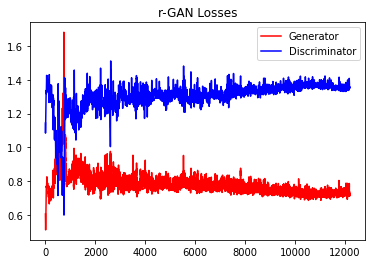

In [ ]:
def running_mean(data, periods=10):
    # from https://github.com/artemsavkin/latent3d/blob/master/pcl_latent3d_shapenet.ipynb
    weights = np.ones(periods) / periods
    return np.convolve(data, weights, mode='valid')

rm_losses_gen = running_mean(np.asarray(losses_gen))
rm_losses_dis = running_mean(np.asarray(losses_dis))


plt.plot(range(0, len(rm_losses_gen)), rm_losses_gen, 'r-', label='Generator')
plt.plot(range(0, len(rm_losses_dis)), rm_losses_dis, 'b-', label='Discriminator')
plt.gca().patch.set_alpha(0)
plt.title('r-GAN Losses')
plt.legend()
plt.show()

## Save the model

In [18]:

torch.save(
    {
      'raw_gan_generator': raw_gan_gen.state_dict(),
      'raw_gan_discriminator': raw_gan_dis.state_dict()
    },
    shape_name+'_raw_gan.tar'
    )


In [19]:
loaded_model = torch.load(shape_name+'_raw_gan.tar', map_location=device)
loaded_model['raw_gan_generator']

OrderedDict([('model.0.weight',
              tensor([[ 0.1190,  0.0831,  0.0882,  ..., -0.0482, -0.1233,  0.1005],
                      [-0.1286,  0.0364,  0.0333,  ...,  0.0831,  0.0633,  0.0574],
                      [-0.0224, -0.0721,  0.0602,  ...,  0.0270, -0.1080, -0.0811],
                      ...,
                      [ 0.1639,  0.1573,  0.1633,  ..., -0.0636, -0.0497,  0.1707],
                      [-0.0158,  0.0203,  0.1050,  ..., -0.0466, -0.0348,  0.0963],
                      [ 0.0476,  0.0435, -0.0108,  ...,  0.0729, -0.1335,  0.1009]],
                     device='cuda:0')),
             ('model.0.bias',
              tensor([-0.0232, -0.0461,  0.0150, -0.0259, -0.0069, -0.0089, -0.0564, -0.0165,
                      -0.0024, -0.0300, -0.0244, -0.0354, -0.0108, -0.0173, -0.0316, -0.0372,
                       0.0022, -0.0481, -0.0451, -0.0132, -0.0148, -0.0169, -0.0289, -0.0308,
                      -0.0182,  0.0144, -0.0165, -0.0089, -0.0545, -0.0344, -0.0306,

### Generate samples

(50, 3, 2048)
(50, 3, 2048)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


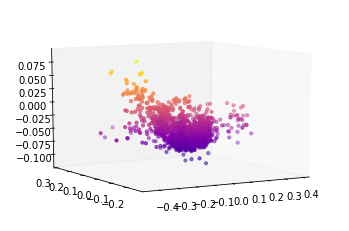

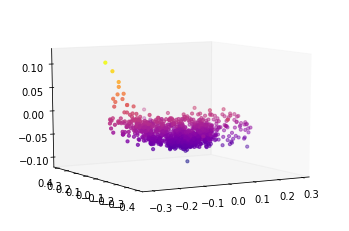

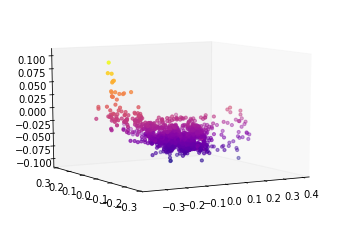

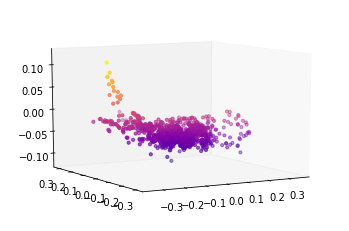

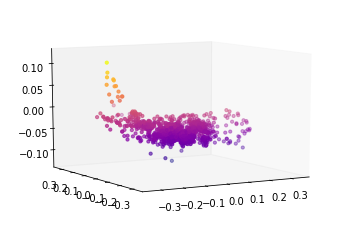

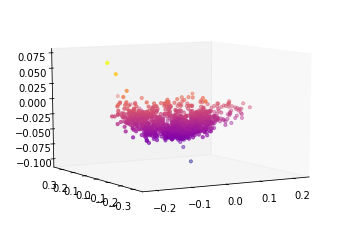

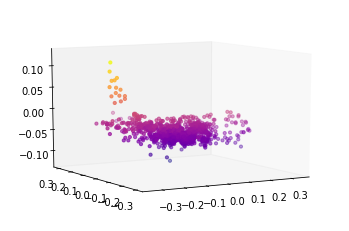

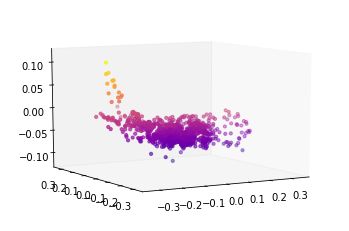

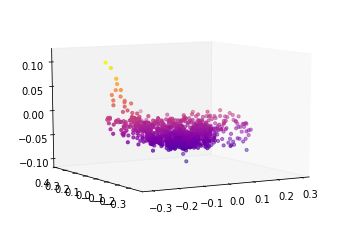

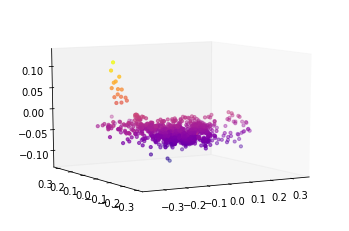

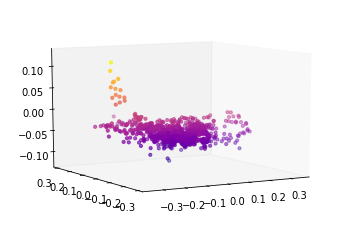

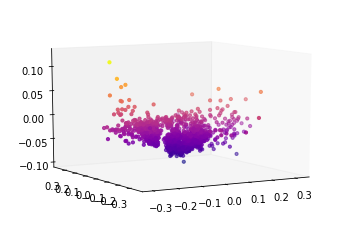

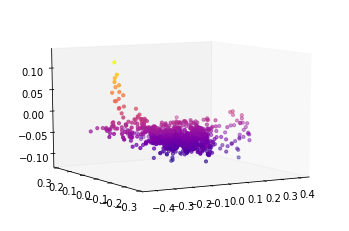

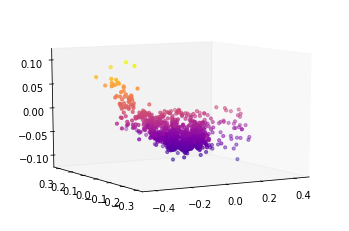

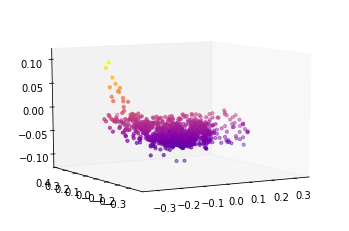

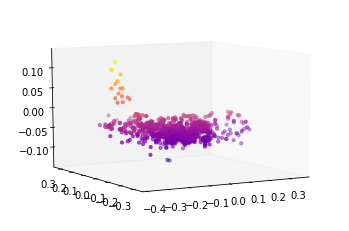

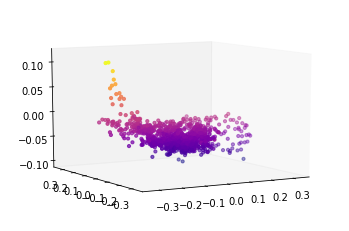

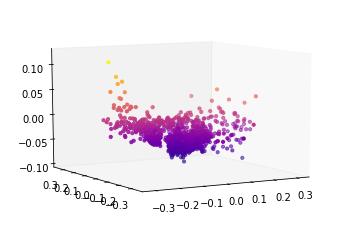

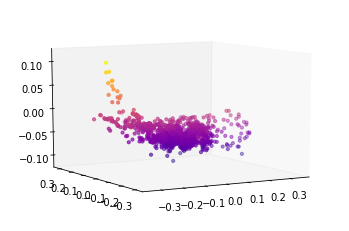

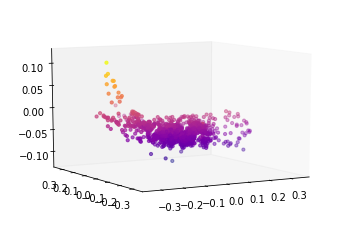

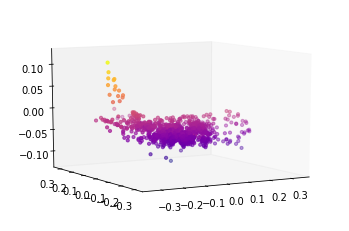

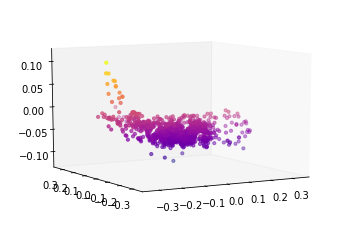

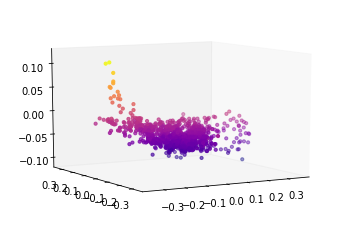

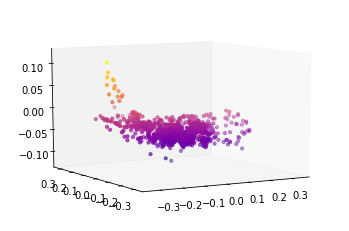

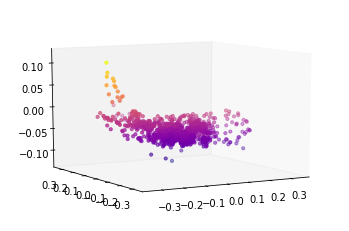

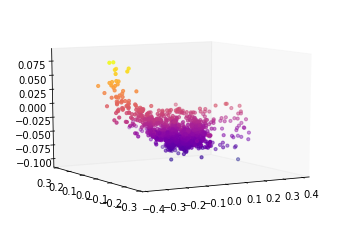

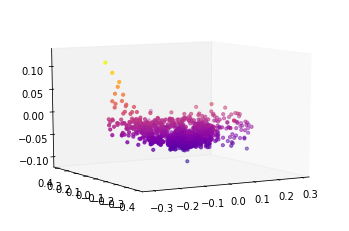

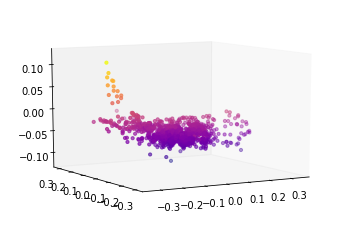

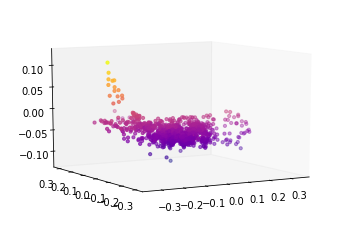

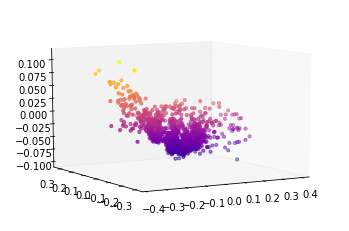

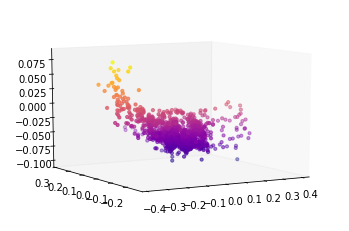

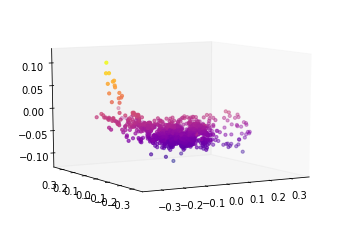

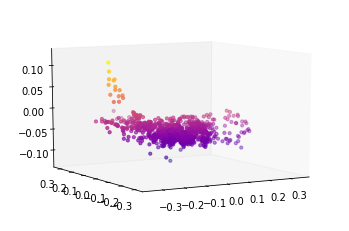

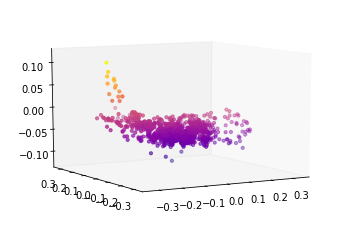

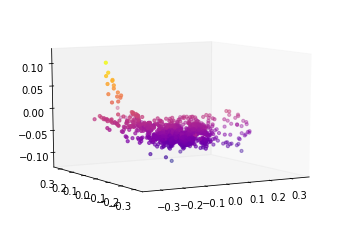

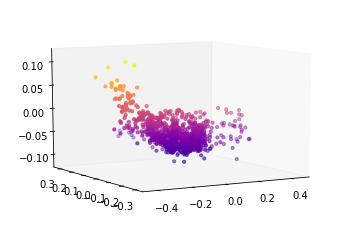

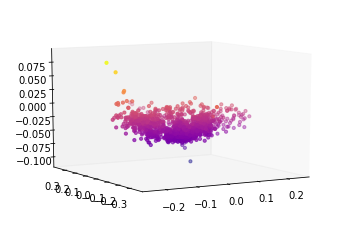

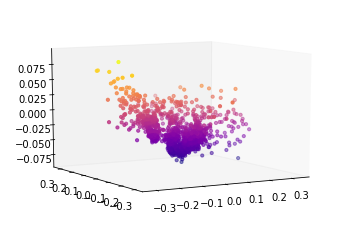

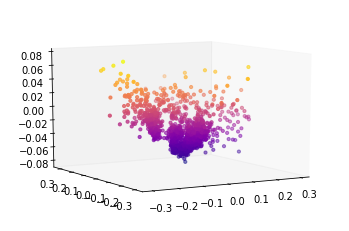

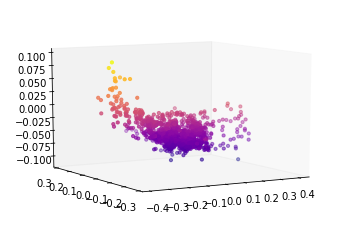

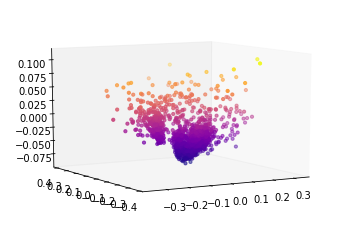

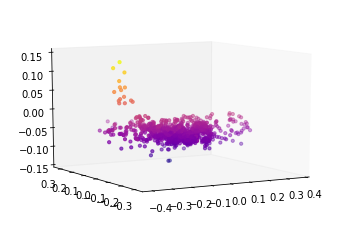

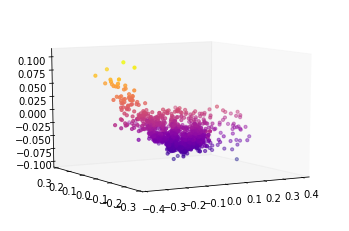

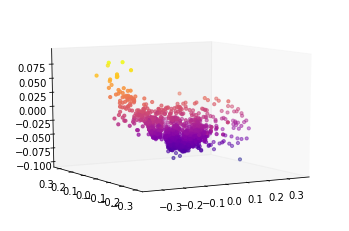

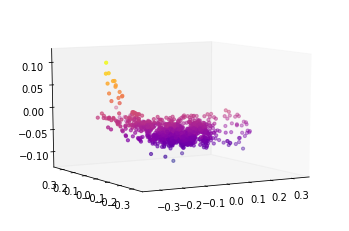

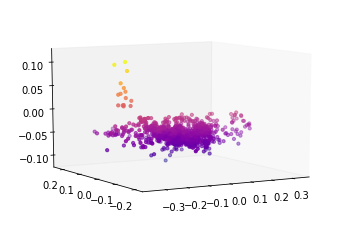

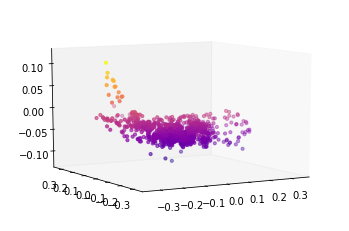

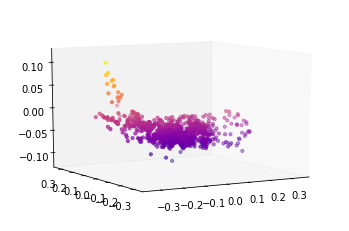

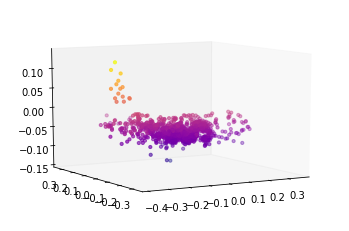

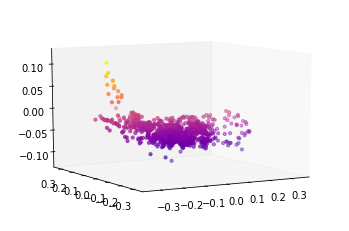

In [21]:
batch_idx, batch_data = next(enumerate(dataloader))
x = batch_data.pos.reshape(batch_size, n_points, 3).transpose(2, 1).cpu().detach().numpy()

# sample the noise vector:
z = torch.Tensor(batch_size, raw_gan_gen_input_dim).normal_(mu, sigma).to(device)
gen_samples = raw_gan_gen(z).cpu().detach().numpy()

print(x.shape)
print(gen_samples.shape)


for i in range(batch_size):
  visualize_points(gen_samples[i].transpose(1,0), is_shapenet=True)
  # visualize_real_and_generated_samples([x[i].transpose(1,0), gen_samples[i].transpose(1,0)], is_shapenet=True)